In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
from torchvision.models import efficientnet_b1
import matplotlib.pyplot as plt

# ================================
# 1. Load EfficientNet-B1 with Pre-trained Weights
# ================================
model = efficientnet_b1(weights=True).to("cuda")

# Modify the classifier for binary classification
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 1)  # Change the output to 1 for binary classification
).to("cuda")

# ================================
# 2. Define Transforms
# ================================
train_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ================================
# 3. Load Dataset and Split
# ================================
data_dir = '/content/drive/MyDrive/dataset_Eff_2/dataset_Eff_2'

dataset = ImageFolder(root=data_dir, transform=train_transforms)
labels = np.array([label for _, label in dataset.samples])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_indices, val_indices = next(split.split(np.zeros(len(labels)), labels))

train_dataset = Subset(ImageFolder(root=data_dir, transform=train_transforms), train_indices)
val_dataset = Subset(ImageFolder(root=data_dir, transform=val_transforms), val_indices)
val_dataset.dataset.transform = val_transforms

# ================================
# 4. Initialize DataLoaders
# ================================
train_loader = DataLoader(train_dataset, batch_size=8, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=4)

# ================================
# 5. Training Loop
# ================================
criterion = nn.BCEWithLogitsLoss().to("cuda")
optimizer = optim.AdamW(model.parameters(), lr=0.00005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

scaler = torch.cuda.amp.GradScaler()

num_epochs = 30
patience = 5
trigger_times = 0
best_val_f1 = -1.0

# Metrics storage
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')

    # ================================
    # Training Phase
    # ================================
    model.train()
    running_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for inputs, labels_batch in tqdm(train_loader, desc="Training"):
        inputs = inputs.to('cuda', non_blocking=True)
        labels_batch = labels_batch.to('cuda', non_blocking=True).float()

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Store predictions and labels
        train_preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
        all_train_preds.extend(train_preds)
        all_train_labels.extend(labels_batch.detach().cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_accuracies.append(train_accuracy)

    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

    # ================================
    # Validation Phase
    # ================================
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels_batch in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to('cuda', non_blocking=True)
            labels_batch = labels_batch.to('cuda', non_blocking=True).float()

            with torch.cuda.amp.autocast():
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels_batch)

            val_loss += loss.item()

            # Store predictions and labels
            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels_batch.detach().cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    val_precision = precision_score(all_labels, all_preds)
    val_recall = recall_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}')

    # ================================
    # Early Stopping and Model Saving
    # ================================
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'No improvement in validation F1-Score for {trigger_times} epoch(s).')

    if trigger_times >= patience:
        print(f'Early stopping triggered after {patience} epochs without improvement.')
        break

    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.Grad


Epoch 1/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:45<00:00,  2.98it/s]


Training Loss: 0.4903, Training Accuracy: 0.8018


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.85it/s]


Validation Loss: 0.1625, Accuracy: 0.9780, Precision: 0.9728, Recall: 0.9835, F1-Score: 0.9781
Best model saved.

Epoch 2/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:43<00:00,  3.15it/s]


Training Loss: 0.1681, Training Accuracy: 0.9560


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s]


Validation Loss: 0.0656, Accuracy: 0.9835, Precision: 0.9889, Recall: 0.9780, F1-Score: 0.9834
Best model saved.

Epoch 3/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:43<00:00,  3.16it/s]


Training Loss: 0.0769, Training Accuracy: 0.9881


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.99it/s]


Validation Loss: 0.0455, Accuracy: 0.9835, Precision: 0.9944, Recall: 0.9725, F1-Score: 0.9833
No improvement in validation F1-Score for 1 epoch(s).

Epoch 4/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


Training Loss: 0.0505, Training Accuracy: 0.9927


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]


Validation Loss: 0.0345, Accuracy: 0.9918, Precision: 0.9891, Recall: 0.9945, F1-Score: 0.9918
Best model saved.

Epoch 5/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:43<00:00,  3.17it/s]


Training Loss: 0.0520, Training Accuracy: 0.9936


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]


Validation Loss: 0.0319, Accuracy: 0.9918, Precision: 0.9891, Recall: 0.9945, F1-Score: 0.9918
No improvement in validation F1-Score for 1 epoch(s).

Epoch 6/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:43<00:00,  3.15it/s]


Training Loss: 0.0458, Training Accuracy: 0.9954


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


Validation Loss: 0.0308, Accuracy: 0.9918, Precision: 0.9945, Recall: 0.9890, F1-Score: 0.9917
No improvement in validation F1-Score for 2 epoch(s).

Epoch 7/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:44<00:00,  3.10it/s]


Training Loss: 0.0300, Training Accuracy: 0.9982


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


Validation Loss: 0.0283, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1-Score: 0.9945
Best model saved.

Epoch 8/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:45<00:00,  3.01it/s]


Training Loss: 0.0197, Training Accuracy: 0.9963


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


Validation Loss: 0.0276, Accuracy: 0.9945, Precision: 0.9891, Recall: 1.0000, F1-Score: 0.9945
Best model saved.

Epoch 9/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:44<00:00,  3.08it/s]


Training Loss: 0.0157, Training Accuracy: 0.9982


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.93it/s]


Validation Loss: 0.0295, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1-Score: 0.9945
No improvement in validation F1-Score for 1 epoch(s).

Epoch 10/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:43<00:00,  3.14it/s]


Training Loss: 0.0173, Training Accuracy: 0.9963


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]


Validation Loss: 0.0274, Accuracy: 0.9918, Precision: 0.9891, Recall: 0.9945, F1-Score: 0.9918
No improvement in validation F1-Score for 2 epoch(s).

Epoch 11/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:43<00:00,  3.18it/s]


Training Loss: 0.0170, Training Accuracy: 0.9972


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  5.05it/s]


Validation Loss: 0.0303, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1-Score: 0.9945
No improvement in validation F1-Score for 3 epoch(s).

Epoch 12/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:42<00:00,  3.20it/s]


Training Loss: 0.0072, Training Accuracy: 1.0000


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  4.95it/s]


Validation Loss: 0.0266, Accuracy: 0.9945, Precision: 0.9891, Recall: 1.0000, F1-Score: 0.9945
No improvement in validation F1-Score for 4 epoch(s).

Epoch 13/30


Training:   0%|          | 0/137 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 137/137 [00:42<00:00,  3.22it/s]


Training Loss: 0.0052, Training Accuracy: 1.0000


Validation:   0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-a3e4a4342369>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 46/46 [00:09<00:00,  5.00it/s]

Validation Loss: 0.0250, Accuracy: 0.9918, Precision: 0.9891, Recall: 0.9945, F1-Score: 0.9918
No improvement in validation F1-Score for 5 epoch(s).
Early stopping triggered after 5 epochs without improvement.


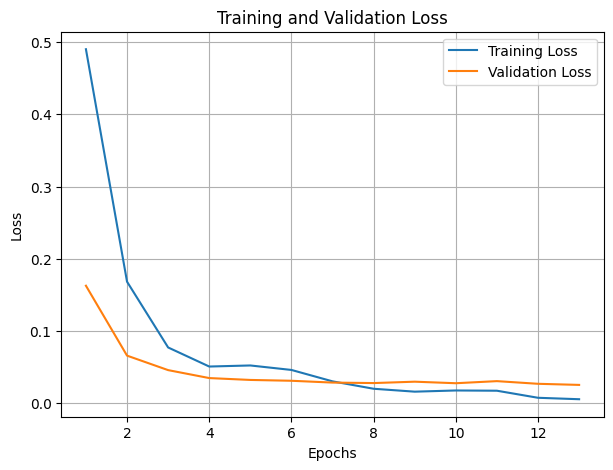

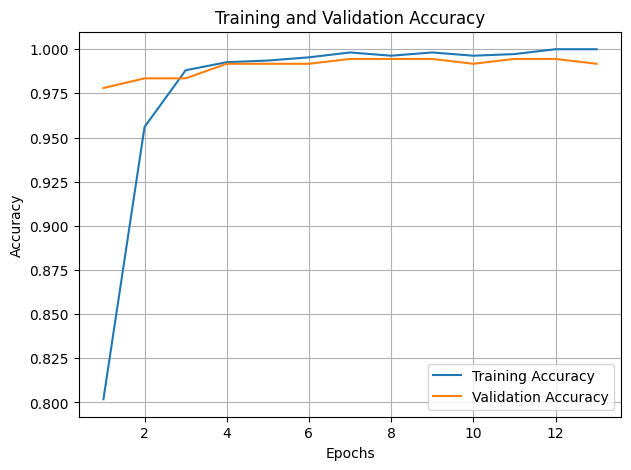

In [ ]:
# ================================
# Plot Metrics
# ================================
epochs = range(1, len(train_losses) + 1)

# Plot Losses
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracies
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# Inference Code

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b1
from PIL import Image, ImageEnhance
import numpy as np
import cv2

# Global variables to hold the model and device
_model = None
_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Test-Time Augmentation (TTA) transforms
_tta_transforms = [
    transforms.Compose([
        transforms.Resize((640, 640)),  # Original scale (100%)
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.Resize((768, 768)),  # 120% scale
        transforms.CenterCrop((640, 640)),         # Crop back to 640x640
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.Resize((768 + 128, 768 + 128)),  # 140% scale
        transforms.CenterCrop((640, 640)),         # Crop back to 640x640
        transforms.ToTensor(),
    ]),
]

def get_class_name(image_path):
    """
    Predicts the class of an image given its file path.

    Args:
        image_path (str): The file path to the input image.

    Returns:
        str: The predicted class name ('non-box' or 'box').
    """
    global _model

    # Load the model only once
    if _model is None:
        # Initialize the EfficientNet-B1 model without pre-trained weights
        _model = efficientnet_b1(weights=None)

        # Modify the classifier to match the number of classes (binary classification)
        num_features = _model.classifier[1].in_features
        _model.classifier = nn.Sequential(
            nn.Linear(num_features, 1)  # Output layer for binary classification
        )

        # Load the saved model weights
        try:
            _model.load_state_dict(torch.load('best_model.pth', map_location=_device))
        except FileNotFoundError:
            raise FileNotFoundError("The model file 'best_model.pth' was not found.")
        except Exception as e:
            raise RuntimeError(f"An error occurred while loading the model: {e}")

        # Move the model to the appropriate device (GPU or CPU)
        _model.to(_device)

        # Set the model to evaluation mode
        _model.eval()

    # ========================
    # Image Preprocessing Steps
    # ========================

    try:
        # Open the image and convert to RGB
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        raise FileNotFoundError(f"The image file '{image_path}' was not found.")
    except Exception as e:
        raise RuntimeError(f"An error occurred while opening the image: {e}")

    # ========================
    # Prediction with TTA
    # ========================

    predictions = []

    # Apply each fixed-scale transformation for TTA
    for transform in _tta_transforms:
        # Apply the transformation
        input_tensor = transform(image)

        # Add batch dimension and move to device
        input_batch = input_tensor.unsqueeze(0).to(_device)

        # Perform inference without tracking gradients
        with torch.no_grad():
            output = _model(input_batch)

        # Convert output to probability using sigmoid
        probability = torch.sigmoid(output[0]).item()
        predictions.append(probability)

    # Calculate the average probability across all TTA scales
    avg_probability = sum(predictions) / len(predictions)

    # Define class labels
    classes = ['non-box', 'box']

    # Determine the class based on the average probability
    predicted_class = 1 if avg_probability >= 0.5 else 0

    return predicted_class

In [ ]:
classes = ['non-box', 'box']
image_path = "sample/2 (10).jpg"
result = get_class_name(image_path)
print(f"The predicted class is: {classes[result]}")

/tmp/ipykernel_3013386/4284673994.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _model.load_state_dict(torch.load('best_modelEfficientNetPreTrained.pth', map_location

The predicted class is: non-box


# Evaluate Testset

100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Accuracy: 0.9950
Precision (class 0 - non-box): 1.0000, Precision (class 1 - box): 0.9901
Recall (class 0 - non-box): 0.9900, Recall (class 1 - box): 1.0000
F1-Score (class 0 - non-box): 0.9950, F1-Score (class 1 - box): 0.9950
Macro Precision: 0.9950, Macro Recall: 0.9950, Macro F1-Score: 0.9950


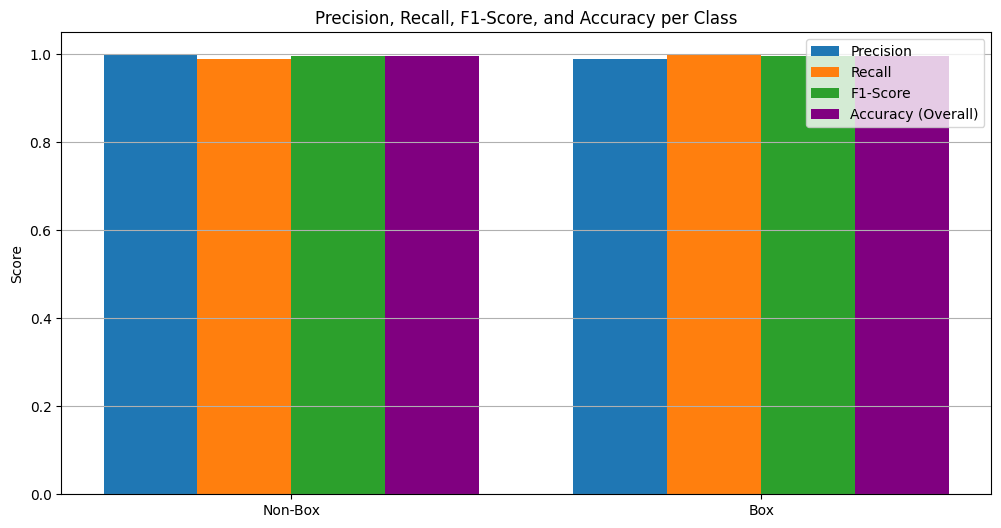

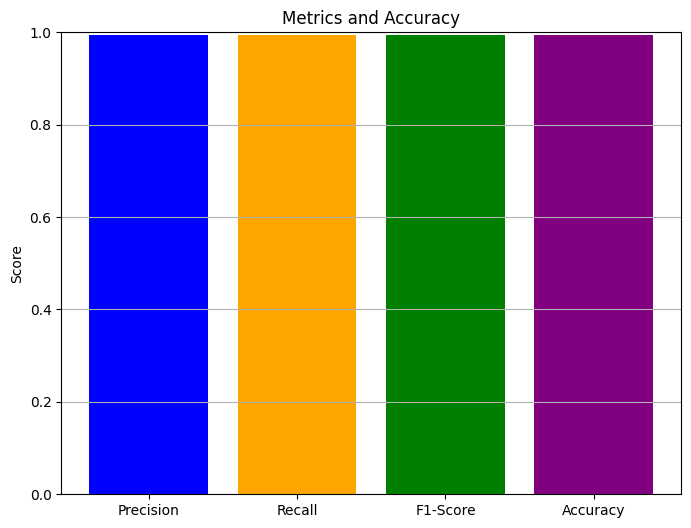

In [ ]:
from glob import glob
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

total = 0
correct = 0

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate for 'xbox' (class 1)
for image_path in tqdm(glob("/content/drive/MyDrive/boxes_classification_test_2/boxes_classification_test_2/xbox/*")):
    result = get_class_name(image_path)
    true_labels.append(1)  # True label for 'xbox'
    predicted_labels.append(result)  # Predicted label
    total += 1
    correct += int(result == 1)

# Evaluate for 'non-box' (class 0)
for image_path in tqdm(glob("/content/drive/MyDrive/boxes_classification_test_2/boxes_classification_test_2/non-box/*")):
    result = get_class_name(image_path)
    true_labels.append(0)  # True label for 'non-box'
    predicted_labels.append(result)  # Predicted label
    total += 1
    correct += int(result == 0)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)  # Per class precision
recall = recall_score(true_labels, predicted_labels, average=None)  # Per class recall
f1 = f1_score(true_labels, predicted_labels, average=None)  # Per class F1-score

# Macro averages
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (class 0 - non-box): {precision[0]:.4f}, Precision (class 1 - box): {precision[1]:.4f}")
print(f"Recall (class 0 - non-box): {recall[0]:.4f}, Recall (class 1 - box): {recall[1]:.4f}")
print(f"F1-Score (class 0 - non-box): {f1[0]:.4f}, F1-Score (class 1 - box): {f1[1]:.4f}")
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-Score: {macro_f1:.4f}")

# ================================
# Plotting the Metrics
# ================================
# Data for plotting
classes = ['Non-Box', 'Box']
x = np.arange(len(classes))

# Plot Precision, Recall, F1-Score, and Accuracy for each class
plt.figure(figsize=(12, 6))
plt.bar(x - 0.3, precision, width=0.2, label='Precision', align='center')
plt.bar(x - 0.1, recall, width=0.2, label='Recall', align='center')
plt.bar(x + 0.1, f1, width=0.2, label='F1-Score', align='center')
plt.bar(x + 0.3, [accuracy, accuracy], width=0.2, label='Accuracy (Overall)', align='center', color='purple')
plt.xticks(x, classes)
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score, and Accuracy per Class")
plt.legend()
plt.grid(axis='y')
plt.show()

# Plot Macro-Averaged Metrics including Accuracy
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
macro_scores = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(8, 6))
plt.bar(metrics, macro_scores, color=['blue', 'orange', 'green', 'purple'])
plt.ylabel("Score")
plt.title("Metrics and Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()